## Visualizing the effect of scaling methods

Adapted from:

Raschka, S. "About feature scaling and normalization–and the effect of standardization for machine learning algorithms. Sebastian Raschka. 2014." (2014).
Accessed from: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [1]:
import itertools
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import sklearn.datasets as skd

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


import kdquantile

In [2]:
columns = ['Wing', 'Weight', 'Culmen', 'Hallux', 'Tail']
# Downloaded from https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Hawks.csv
df = pd.io.parsers.read_csv('Hawks.csv')
df = df[columns+['Species']]
df = df.dropna()
X_hawks = df[columns].values
y_hawks = df[['Species']].values.flatten()
display(df.head())
np.unique(y_hawks)

,Wing,Weight,Culmen,Hallux,Tail,Species
0,385.0,920.0,25.7,30.1,219,RT
2,381.0,990.0,26.7,31.3,235,RT
3,265.0,470.0,18.7,23.5,220,CH
4,205.0,170.0,12.5,14.3,157,SS
5,412.0,1090.0,28.5,32.2,230,RT


array(['CH', 'RT', 'SS'], dtype=object)

## The effect of standardization on PCA in a pattern classification task

/Users/calvinm/miniconda3/envs/ksquantile/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (623). n_quantiles is set to n_samples.
  warnings.warn(


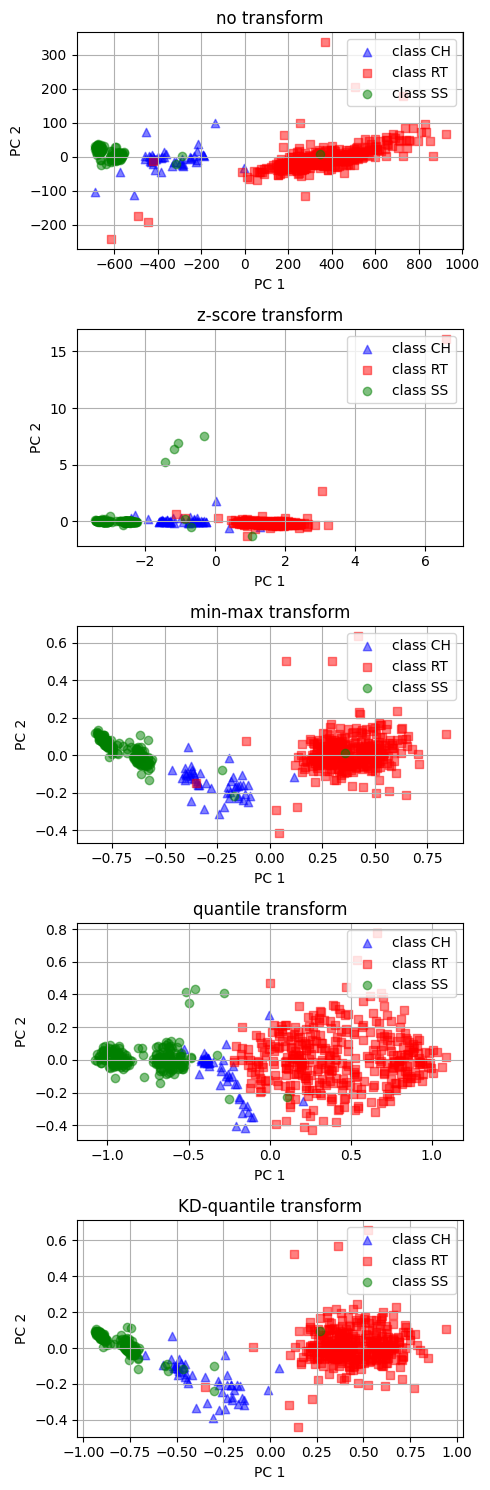

Transform 	 Train+Full 	 Train+PCA 	 Test+Full 	 Test+PCA
no          	 98.39% 	 97.43% 	 98.88% 	 97.39%
z-score     	 98.39% 	 98.07% 	 98.88% 	 98.88%
min-max     	 98.39% 	 97.75% 	 98.88% 	 98.13%
quantile    	 96.31% 	 94.54% 	 96.64% 	 95.52%
KD-quantile 	 98.72% 	 97.43% 	 99.25% 	 98.13%


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hawks, y_hawks,
    test_size=0.30, random_state=12345)

X_dict = {}

# On raw data
pca = PCA(n_components=2).fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)
X_dict['no'] = {
    'train': {'pc': X_train_pc, 'full': X_train}, 
    'test': {'pc': X_test_pc, 'full': X_test},
}

# On preprocessed data
methods = [
    (preprocessing.StandardScaler, 'z-score'),
    (preprocessing.MinMaxScaler, 'min-max'),
    (preprocessing.QuantileTransformer, 'quantile'),
    (kdquantile.KDQuantileTransformer, 'KD-quantile'),
]
for preprocessor, pname in methods:
    prepper = preprocessor().fit(X_train)
    X_train_prepped = prepper.transform(X_train)
    X_test_prepped = prepper.transform(X_test)
    pcaer = PCA(n_components=2).fit(X_train_prepped)
    X_train_prepped_pc = pcaer.transform(X_train_prepped)
    X_test_prepped_pc = pcaer.transform(X_test_prepped)
    X_dict[pname] = {
        'train': {'pc': X_train_prepped_pc, 'full': X_train_prepped},
        'test': {'pc': X_test_prepped_pc, 'full': X_test_prepped},
    }

fig, axes = plt.subplots(nrows=len(X_dict), figsize=(5,3*len(X_dict)))

for ax, pname in zip(axes, list(X_dict.keys())):
    X_pc = X_dict[pname]['train']['pc']
    for l,c,m in zip(['CH', 'RT', 'SS'], ('blue', 'red', 'green'), ('^', 's', 'o')):
        ax.scatter(X_pc[y_train==l, 0], X_pc[y_train==l, 1],
            color=c, label='class %s' % l, alpha=0.5, marker=m
        )
    ax.set_title('{} transform'.format(pname))    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()

print('Transform \t Train+Full \t Train+PCA \t Test+Full \t Test+PCA')
res_dict = {}
for pname in list(X_dict.keys()):
    gnb_full = GaussianNB()    
    gnb_pc = GaussianNB()
    gnb_full.fit(X_dict[pname]['train']['full'], y_train)
    gnb_pc.fit(X_dict[pname]['train']['pc'], y_train)
    pred_train_full = gnb_full.predict(X_dict[pname]['train']['full'])
    pred_train_pc = gnb_pc.predict(X_dict[pname]['train']['pc'])
    pred_test_full = gnb_full.predict(X_dict[pname]['test']['full'])
    pred_test_pc = gnb_pc.predict(X_dict[pname]['test']['pc'])
    acc_train_full = metrics.accuracy_score(y_train, pred_train_full)
    acc_train_pc = metrics.accuracy_score(y_train, pred_train_pc)
    acc_test_full = metrics.accuracy_score(y_test, pred_test_full)
    acc_test_pc = metrics.accuracy_score(y_test, pred_test_pc)
    print(f'{pname:<11} \t {acc_train_full:.2%} \t {acc_train_pc:.2%} \t {acc_test_full:.2%} \t {acc_test_pc:.2%}')
    #res_dict[pname] = {'Test+Full': acc_test_full, 'Test+PCA': acc_test_pc}
    res_dict[pname] = {
        'train': {'pc': acc_train_pc, 'full': acc_train_full},
        'test': {'pc': acc_test_pc, 'full': acc_test_full},
    }

In [4]:
n_random = 100
n_alphas = 20
alphas = list(np.geomspace(0.1, 10, n_alphas))
methods = [
    (preprocessing.StandardScaler, 'z-score'),
    (preprocessing.MinMaxScaler, 'min-max'),
    (preprocessing.QuantileTransformer, 'quantile'),
    (kdquantile.KDQuantileTransformer, 'KD-quantile'),
]
random_states = list(np.random.randint(0, 12345, size=n_random))
test_dict = {}
for mname in ['no']+[mname for _, mname in methods]:
    test_dict[mname] = {'pc': np.zeros(n_random), 'full': np.zeros(n_random)}

alpha_dict = {'pc': np.zeros((n_random, n_alphas)), 'full': np.zeros((n_random, n_alphas))}
for rix, rstate in enumerate(random_states):
    X_train, X_test, y_train, y_test = train_test_split(
        X_hawks, y_hawks, test_size=0.30, random_state=rstate)
    
    pca = PCA(n_components=2).fit(X_train)
    X_train_pc = pca.transform(X_train)
    X_test_pc = pca.transform(X_test)
    gnb_full = GaussianNB().fit(X_train, y_train)
    gnb_pc = GaussianNB().fit(X_train_pc, y_train)
    acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test))
    acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_pc))
    test_dict['no']['full'][rix] = acc_test_full
    test_dict['no']['pc'][rix] = acc_test_pc
    
    for preprocessor, pname in methods:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prepper = preprocessor().fit(X_train)
        X_train_prepped = prepper.transform(X_train)
        X_test_prepped = prepper.transform(X_test)
        pcaer = PCA(n_components=2).fit(X_train_prepped)
        X_train_prepped_pc = pcaer.transform(X_train_prepped)
        X_test_prepped_pc = pcaer.transform(X_test_prepped)

        gnb_full = GaussianNB().fit(X_train_prepped, y_train)
        gnb_pc = GaussianNB().fit(X_train_prepped_pc, y_train)
        acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test_prepped))
        acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_prepped_pc))
        test_dict[pname]['full'][rix] = acc_test_full
        test_dict[pname]['pc'][rix] = acc_test_pc

    for aix, alpha in enumerate(alphas):
        prepper = kdquantile.KDQuantileTransformer(alpha=alpha).fit(X_train)
        X_train_prepped = prepper.transform(X_train)
        X_test_prepped = prepper.transform(X_test)
        pcaer = PCA(n_components=2).fit(X_train_prepped)
        X_train_prepped_pc = pcaer.transform(X_train_prepped)
        X_test_prepped_pc = pcaer.transform(X_test_prepped)
        gnb_full = GaussianNB().fit(X_train_prepped, y_train)
        gnb_pc = GaussianNB().fit(X_train_prepped_pc, y_train)
        acc_test_full = metrics.accuracy_score(y_test, gnb_full.predict(X_test_prepped))
        acc_test_pc = metrics.accuracy_score(y_test, gnb_pc.predict(X_test_prepped_pc))
        alpha_dict['pc'][rix, aix] = acc_test_pc
        alpha_dict['full'][rix, aix] = acc_test_full

for dname in ['full', 'pc']:
    for mname in ['no']+[mname for _, mname in methods]:
        mean = np.mean(test_dict[mname][dname])
        print(f'{mname:<11} {dname:<5} {mean:.4%}')
for dname in ['full', 'pc']:
    mean = np.mean(alpha_dict[dname], axis=0)
    print(f'{dname:<5} {mean}')


no          full  98.3582%
z-score     full  98.3582%
min-max     full  98.3582%
quantile    full  96.6007%
KD-quantile full  98.3694%
no          pc    97.5821%
z-score     pc    97.9216%
min-max     pc    98.0560%
quantile    pc    94.2724%
KD-quantile pc    97.9925%
full  [0.97369403 0.97492537 0.97671642 0.97899254 0.98089552 0.98343284
 0.98354478 0.98380597 0.98373134 0.98391791 0.98384328 0.98376866
 0.98458955 0.98440299 0.98429104 0.98440299 0.98470149 0.9844403
 0.98421642 0.98406716]
pc    [0.94776119 0.95089552 0.95518657 0.96078358 0.96604478 0.97
 0.97324627 0.97768657 0.98014925 0.98041045 0.97992537 0.98022388
 0.98085821 0.98104478 0.98093284 0.9808209  0.98070896 0.98074627
 0.98074627 0.98070896]


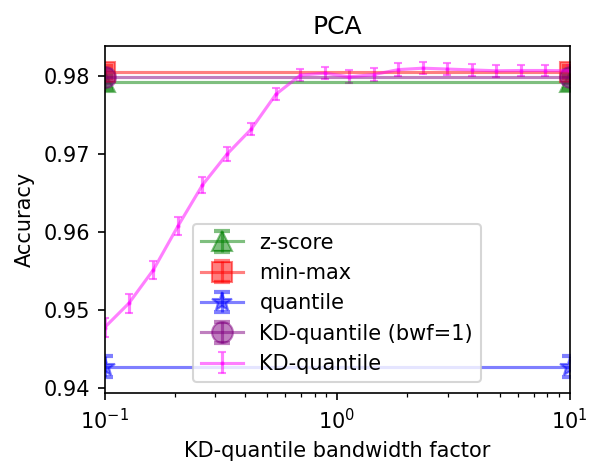

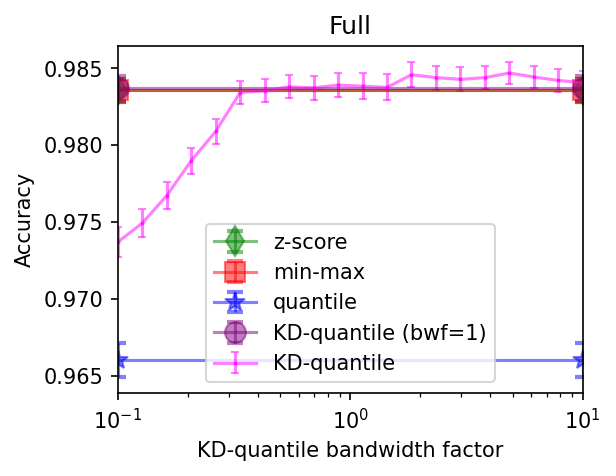

In [5]:
markers = itertools.cycle(('^', 's', '*', 'o', '.'))
colors = itertools.cycle(('green', 'red', 'blue', 'purple', 'magenta')) 
alph = np.array([np.min(alphas), np.max(alphas)]);
fig = plt.figure(figsize=(4,3), dpi=150)
for pname in list(res_dict.keys()):
    if pname == 'no':
        continue
    tmean = test_dict[pname]['pc'].mean()
    tstd = np.std(test_dict[pname]['pc'], ddof=1) / np.sqrt(n_random)
    (_, caps, _) = plt.errorbar(
        alph, tmean*np.ones(2), yerr=tstd*np.ones(2), 
        marker=next(markers), c = next(colors), markersize=10, alpha=0.5, capsize=4,
        label=f'{pname} (bwf=1)' if pname=='KD-quantile' else pname);
    for cap in caps:
        cap.set_markeredgewidth(2)
amean = alpha_dict['pc'].mean(axis=0)
astd = np.std(alpha_dict['pc'], axis=0, ddof=1) / np.sqrt(n_random)
plt.errorbar(
    alphas, amean, yerr=astd,
    marker=next(markers), c=next(colors), markersize=2, alpha=0.5, capsize=2,
    label='KD-quantile');
plt.xlabel('KD-quantile bandwidth factor');
plt.ylabel('Accuracy');
plt.xscale('log');
#plt.grid();
plt.xlim(np.min(alphas), np.max(alphas));
fig.savefig('accuracy-vs-bwf-hawks-pca-nolegend.pdf', bbox_inches='tight')
plt.legend(loc='lower center');
fig.savefig('accuracy-vs-bwf-hawks-pca.pdf', bbox_inches='tight')
plt.title('PCA');

markers = itertools.cycle(('d', 's', '*', 'o', '.'))
colors = itertools.cycle(('green', 'red', 'blue', 'purple', 'magenta')) 
fig = plt.figure(figsize=(4,3), dpi=150)
for pname in list(res_dict.keys()):
    if pname == 'no':
        continue
    tmean = test_dict[pname]['full'].mean()
    tstd = np.std(test_dict[pname]['full'], ddof=1) / np.sqrt(n_random)
    (_, caps, _) = plt.errorbar(
        alph, tmean*np.ones(2), yerr=tstd*np.ones(2), 
        marker=next(markers), c = next(colors), markersize=10, alpha=0.5, capsize=4,
        label=f'{pname} (bwf=1)' if pname=='KD-quantile' else pname);
    for cap in caps:
        cap.set_markeredgewidth(2)
amean = alpha_dict['full'].mean(axis=0)
astd = np.std(alpha_dict['full'], axis=0, ddof=1) / np.sqrt(n_random)
plt.errorbar(
    alphas, amean, yerr=astd,
    marker=next(markers), c=next(colors), markersize=2, alpha=0.5, capsize=2,
    label='KD-quantile');
plt.legend(loc='lower center');
plt.xlabel('KD-quantile bandwidth factor');
plt.xscale('log');
plt.ylabel('Accuracy');
#plt.grid();
plt.xlim(np.min(alphas), np.max(alphas));
fig.savefig('accuracy-vs-bwf-hawks-full.pdf', bbox_inches='tight')
plt.title('Full');